In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces


class CliffWalking50x50(gym.Env):
    def __init__(self):
        super().__init__()
        self.nrow = 50
        self.ncol = 50
        self.start = (0, 0)
        self.goal = (49, 49)
        self.state = self.start

        self.observation_space = spaces.Discrete(self.nrow * self.ncol)
        self.action_space = spaces.Discrete(4)  # left, down, right, up

        self.pos_to_state = lambda r, c: r * self.ncol + c
        self.state_to_pos = lambda s: (s // self.ncol, s % self.ncol)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start
        return self._get_obs(), {}

    def step(self, action):
        r, c = self.state
        if action == 0:  # left
            c = max(c - 1, 0)
        elif action == 1:  # down
            r = min(r + 1, self.nrow - 1)
        elif action == 2:  # right
            c = min(c + 1, self.ncol - 1)
        elif action == 3:  # up
            r = max(r - 1, 0)

        done = False
        reward = -0.1

        
        if r == self.nrow - 1 and (c != 0 and c != self.ncol - 1):
            reward = -1.0  # cliff penalty
            r, c = self.start
        elif (r, c) == self.goal:
            reward = 1.0
            done = True

        self.state = (r, c)
        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        r, c = self.state
        return self.pos_to_state(r, c)




In [31]:
# Double Q-learning implementation

def double_q_learning(env, episodes=500, gamma=0.99, alpha=0.5, epsilon_start=1.0, epsilon_end=0.05):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))

        while not done:
            Q_sum = Q1[state] + Q2[state]
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_sum)

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            if np.random.rand() < 0.5:
                next_action = np.argmax(Q1[next_state])
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, next_action] - Q1[state, action])
            else:
                next_action = np.argmax(Q2[next_state])
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, next_action] - Q2[state, action])

            state = next_state

        rewards.append(total_reward)
    return Q1 + Q2, rewards





In [32]:
# SARSA Implementation

def sarsa(env, episodes=500, gamma=0.99, alpha=0.5, epsilon_start=1.0, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action

        rewards.append(total_reward)
    return Q, rewards




In [33]:

# Q-Learning Implementation

def q_learning(env, episodes=500, gamma=0.99, alpha=0.5, epsilon_start=1.0, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state

        rewards.append(total_reward)
    return Q, rewards


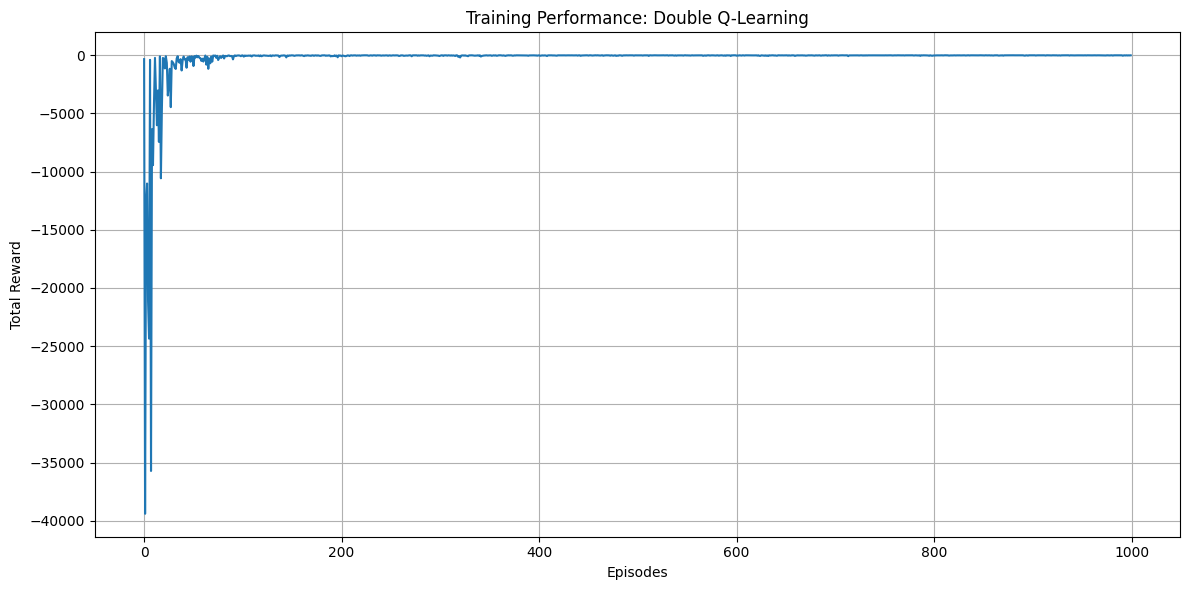

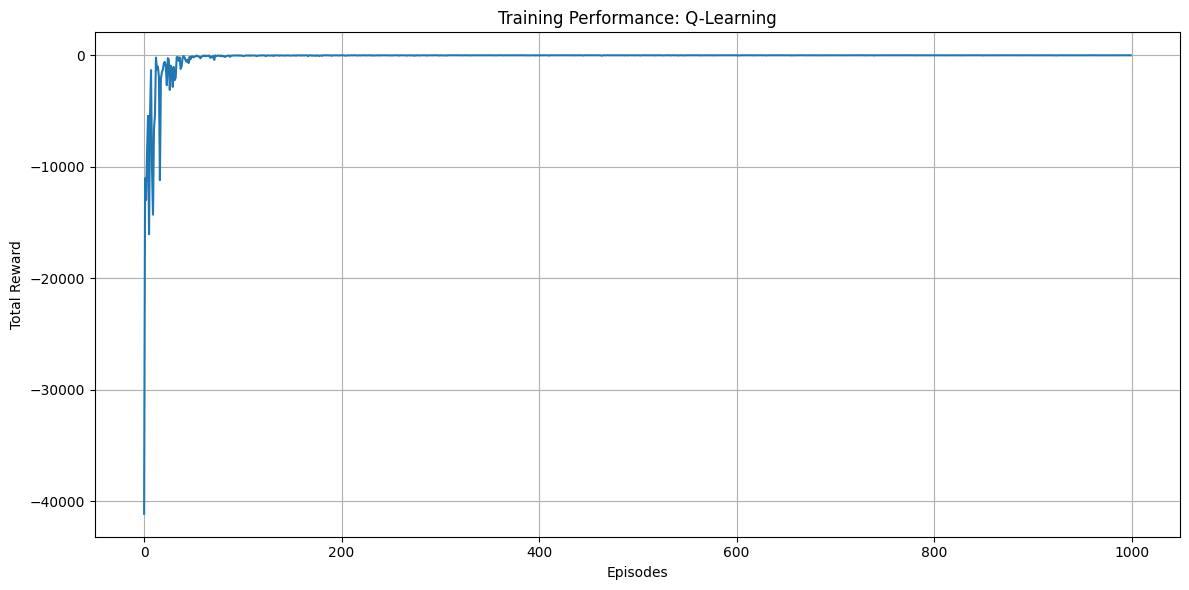

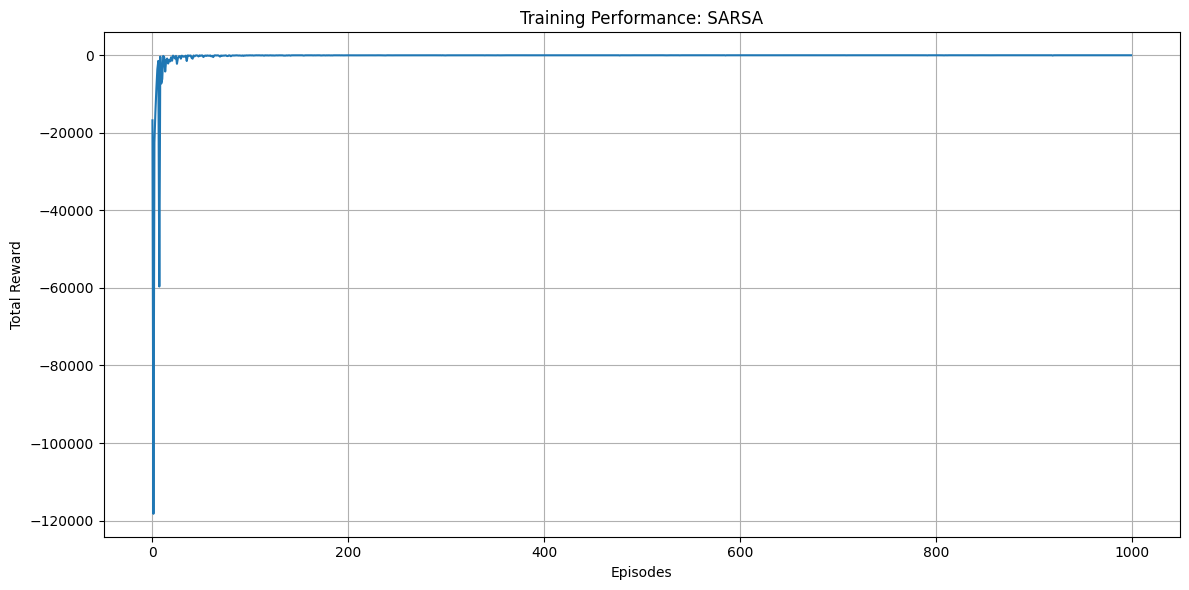

In [ ]:

# Plotting performance

def plot_single_reward(rewards, label="Algorithm Name"):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title(f"Training Performance: {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run all on custom 50x50 CliffWalking
env = CliffWalking50x50()
q_table_dq, rewards_dq = double_q_learning(env, episodes=1000)
plot_single_reward(rewards_dq, label="Double Q-Learning")
q_table_q, rewards_q = q_learning(env, episodes=1000)
plot_single_reward(rewards_q, label="Q-Learning")
q_table_sarsa, rewards_sarsa = sarsa(env, episodes=1000)
plot_single_reward(rewards_sarsa, label="SARSA")

In [35]:


def evaluate(env, Q, episodes=100, max_steps=500):
    total_reward, total_steps = 0, 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        steps, ep_reward = 0, 0
        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            ep_reward += reward
            steps += 1
        total_reward += ep_reward
        total_steps += steps
    return total_reward / episodes, total_steps / episodes


# Run comparison
env = CliffWalking50x50()
for name, algo in [("Q-Learning", q_learning), ("SARSA", sarsa), ("Double Q-Learning", double_q_learning)]:
    start = time.time()
    Q = algo(env)
    duration = time.time() - start
    avg_reward, avg_steps = evaluate(env, Q)
    print(f"{name:<20} Time: {duration:.2f}s  |  Avg Reward: {avg_reward:.2f}  |  Avg Steps: {avg_steps:.2f}")


Q-Learning           Time: 9.45s  |  Avg Reward: -50.00  |  Avg Steps: 500.00
SARSA                Time: 3.46s  |  Avg Reward: -50.00  |  Avg Steps: 500.00
Double Q-Learning    Time: 10.31s  |  Avg Reward: -50.00  |  Avg Steps: 500.00
